In [1]:
## custom
import utils, vis
import optimization as O


## third party
from PIL import Image
from natsort import natsorted
import networkx as nx

import lovasz_losses as L
import poly_point_isect as bo   ##bentley-ottmann sweep line
from pynndescent import NNDescent


## sys
import random
import time
from glob import glob
import math

## numeric
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F

## vis
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


## generate a graph

generating graph of 100 nodes
Calculating all pairs shortest path...


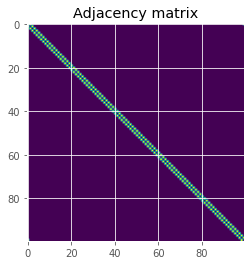

CPU times: user 252 ms, sys: 7.82 ms, total: 260 ms
Wall time: 264 ms


In [25]:
%%time

print('generating graph', end=' ')
G = nx.cycle_graph(100)
print(f'of {len(G.nodes)} nodes')

print('Calculating all pairs shortest path...')
D, k2i = utils.dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
adj,_ = utils.dict2tensor(dict(G.adjacency()), fill=1, device=device)
i2k = {i:k for k,i in k2i.items()}

W = 1/(D+1e-6)**2
truth = adj + torch.eye(adj.shape[0], device=device)

plt.imshow(adj)
plt.title('Adjacency matrix')
plt.show()

## Optimize via Stochastic Gradient Descent (SGD)

  0%|          | 0/10000 [00:00<?, ?it/s]

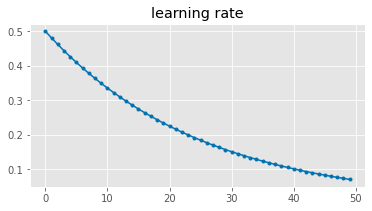

In [36]:
# delete old
!rm -r fig
!mkdir fig

niter = 10000

def getLR(i):
    base_lr = 0.5
    return np.exp(-i*2/niter) * base_lr


pos = torch.rand(len(G.nodes), 2, device=device)
pos.requires_grad_(True)

optimizer = optim.SGD([pos], lr=0.5, momentum=0.9, nesterov=True)
# optimizer = optim.Adam([pos], lr=0.1)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, getLR)


lrs = [getLR(i) for i in range(0,niter,niter//50)]
plt.figure(figsize=[6,3])
plt.plot(lrs, '.-')
plt.title('learning rate')

iterBar = tqdm(range(niter))
lossHistory = []
totalTime = 0

In [27]:
# n_samples = 10


# n,m = pos.shape[0], pos.shape[1]
# sample_ratio = n_samples / n

# if n_samples is not None:
#     i0 = np.random.choice(n, n_samples)
#     x = pos[i0,:]
# else:
#     i0 = range(n)
#     x = pos

# ## k_dist
# max_degree = max(G.degree(n) for n in G.nodes)
# n_neighbors = math.ceil(max_degree * sample_ratio * 2)
# n_neighbors = min(2, n_neighbors)
# n_neighbors = min(max_degree*2, n_neighbors)

# n_trees = min(64, 5 + int(round((n_samples) ** 0.5 / 20.0)))
# n_iters = max(5, int(round(np.log2(n_samples))))

# knn_search_index = NNDescent(
#     x.detach().numpy(),
#     n_neighbors=n_neighbors+1,
#     n_trees=n_trees,
#     n_iters=n_iters,
#     max_candidates=60,
# )
# knn_indices, knn_dists = knn_search_index.neighbor_graph
# knn_indices, knn_dists = knn_indices[:,1:], knn_dists[:,1:]
# degrees = [G.degree(i2k[i]) for i in i0]
# ks = [round(d*sample_ratio) for d in degrees]
# dmax = knn_dists.shape[1]-1
# k_dist = np.array([
#     ( knn_dists[i,k] + knn_dists[i,min(dmax, k+1)] ) / 2 
#     for i,k in enumerate(ks)
# ])


# ## pdist
# x0 = x.repeat(1, n_samples).view(-1,m)
# x1 = x.repeat(n_samples, 1)
# pdist = nn.PairwiseDistance()(x0, x1).view(n_samples, n_samples)
     
    
    
# ## loss 
# pred = pdist - torch.from_numpy(k_dist.astype(np.float32)).view(-1,1)
# target = 1-truth[i0,:][:,i0]
# neighbor_loss = L.lovasz_hinge(pred, target)

# ##vis
# vmax = pred.abs().max()
# plt.figure(figsize=[8,3])
# plt.subplot(121)
# plt.imshow(pred.detach(), vmin=-vmax, vmax=vmax, cmap='coolwarm')
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(target, cmap='coolwarm')
# plt.colorbar()


In [ ]:
def neighborhood_preseration(n_samples=None):

    n,m = pos.shape[0], pos.shape[1]
    sample_ratio = n_samples / n

    if n_samples is not None:
        i0 = np.random.choice(n, n_samples)
        x = pos[i0,:]
    else:
        i0 = range(n)
        x = pos

    ## k_dist
    max_degree = max(G.degree(n) for n in G.nodes)
    n_neighbors = math.ceil(max_degree * sample_ratio * 2)
    n_neighbors = min(2, n_neighbors)
    n_neighbors = min(max_degree*2, n_neighbors)

    n_trees = min(64, 5 + int(round((n_samples) ** 0.5 / 20.0)))
    n_iters = max(5, int(round(np.log2(n_samples))))

    knn_search_index = NNDescent(
        x.detach().numpy(),
        n_neighbors=n_neighbors+1,
        n_trees=n_trees,
        n_iters=n_iters,
        max_candidates=60,
    )
    knn_indices, knn_dists = knn_search_index.neighbor_graph
    knn_indices, knn_dists = knn_indices[:,1:], knn_dists[:,1:]
    degrees = [G.degree(i2k[i]) for i in i0]
    ks = [round(d*sample_ratio) for d in degrees]
    dmax = knn_dists.shape[1]-1
    k_dist = np.array([
        ( knn_dists[i,min(dmax, k)] + knn_dists[i,min(dmax, k+1)] ) / 2 
        for i,k in enumerate(ks)
    ])


    ## pdist
    x0 = x.repeat(1, n_samples).view(-1,m)
    x1 = x.repeat(n_samples, 1)
    pdist = nn.PairwiseDistance()(x0, x1).view(n_samples, n_samples)



    ## loss 
    pred = pdist - torch.from_numpy(k_dist.astype(np.float32)).view(-1,1)
    target = 1-truth[i0,:][:,i0]
    loss = L.lovasz_hinge(pred, target)
    return loss


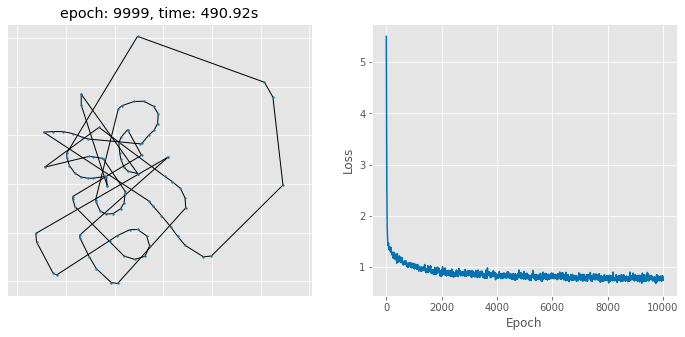

In [37]:
VIS = True
gClamp = 0.1
sampleSize = int(len(G.nodes))


for i in iterBar:
    
    t0 = time.time()
    optimizer.zero_grad()
    
    
    
# ##vis
# vmax = pred.abs().max()
# plt.figure(figsize=[8,3])
# plt.subplot(121)
# plt.imshow(pred.detach(), vmin=-vmax, vmax=vmax, cmap='coolwarm')
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(target, cmap='coolwarm')
# plt.colorbar()

#     samples = getSamples(G, 5, includeNeighbors=False)
#     for si, src in enumerate(samples):
#         for dst in samples[si+1:]:
#             stress_update_ij(X, D, W, src, dst, getLR(i))
            
#     eu = edge_uniformity(X, G, samples)
    loss = (
#           0.0001 * O.stress(pos, D, W, sampleSize)
#         + 0.5 * O.edge_uniformity(pos, G, k2i, sampleSize)
           10*neighbor_loss
        ## TODO: do it efiiciently and stochastically
#         + 0.5 * O.crossing_angle_maximization(pos, G, k2i, sampleSize)
#         + 0.5 * O.neighborhood_preservation(pos, G, k2i, sampleSize)
#         + 0.5 * O.crossings(pos, G, k2i, sampleSize)
#         + 0.5 * O.aspect_ratio(pos, G, k2i, sampleSize)
#         + 0.5 * O.angular_resolution(pos, G, k2i, sampleSize)
    )
    loss.backward()
    pos.grad.clamp_(-gClamp, gClamp)
    optimizer.step()
    
    if scheduler is not None:
        scheduler.step()
    
    
    
    
    
    ##debug info
    dt = time.time() - t0
    totalTime += dt
    if i % int(niter/100) == int(niter/100)-1:
        iterBar.set_postfix({'loss': loss.item()})
    if len(lossHistory)>0:
        lossHistory.append(0.9*lossHistory[-1] + 0.1*loss.item())
    else:
        lossHistory.append(loss.item())
        
    
    
    ##vis
    if VIS and i % int(niter/10) == int(niter/10)-1:
        iterBar.set_postfix({
            'loss': loss.item(),
#             'eu': f'{eu.item():.2e}',
#             'st': f'{st.item():.2e}',
        })
        
        x = pos.detach().cpu().numpy()
        pos_i = {k: x[k2i[k], :2] for k in G.nodes}
        display.clear_output(wait=True)
        vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)


In [ ]:
x = pos.detach().cpu().numpy()
pos_i = {k: x[k2i[k], :2] for k in G.nodes}
vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation

In [ ]:
# Create a gif from images in fig/

frames = []
imgs = natsorted(glob('fig/*.png'))

for img in imgs:
    new_frame = Image.open(img)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)